# Autodiff:  <br> Calculus  from another angle 
(and the special role played by Julia's multiple dispatch and compiler technology)

(Alan Edelman, 2017)


  The first time I heard about automatic differentiation, it was easy for me to imagine what it was.  I was wrong.  In my head, I thought it was straightforward symbolic differentiation applied to code.  I kind of imagined it was like executing Mathematica or Maple, or even just automatically doing what I learned to do in my calculus class. 
  <img src="https://math24.net/images/table-trig-derivatives.svg" width="290">
  .... and anyway if it was not that, then it must be finite differences, like one learns in a numerical computing class.
  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Finite_difference_method.svg/614px-Finite_difference_method.svg.png" width="350">



## Babylonian sqrt

I would like to use a simple example, computation of sqrt(x), where for me how autodiff works came as both a mathematical surprise, and a computing wonder.  The example is  the Babylonian algorithm, known to man for millenia, to compute sqrt(x):  


 > Repeat $ t \leftarrow  (t+x/t) / 2 $ until $t$ converges to $\sqrt{x}$.
 
 Each iteration has one add and two divides. For illustration purposes, 10 iterations suffice.

In [1]:
function Babylonian(x; N = 10) 
    t = (1+x)/2
    for i = 2:N; t=(t + x/t)/2  end    
    t
end  

Babylonian (generic function with 1 method)

In [2]:
using ForwardDiff

In [3]:
ForwardDiff.derivative(Babylonian,2)

0.35355339059327373

In [4]:
.5/sqrt(2)

0.35355339059327373

Check that it works:

In [5]:
α = π
Babylonian(α), √α    

(1.7724538509055159, 1.7724538509055159)

In [6]:
x=2; Babylonian(x),√x  # Type \sqrt+<tab> to get the symbol

(1.414213562373095, 1.4142135623730951)

In [7]:
Babylonian( D(2,1))

LoadError: UndefVarError: `D` not defined

In [8]:
using Plots

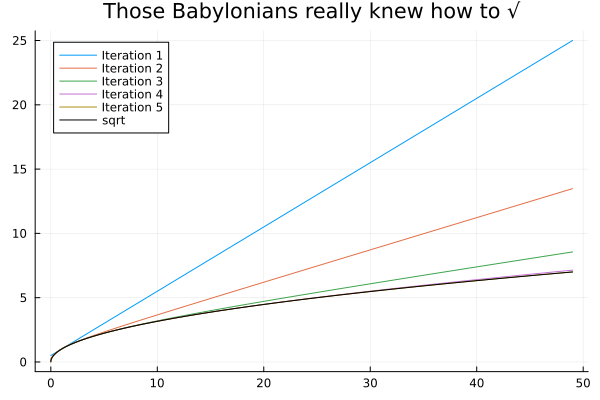

In [9]:
i = 0:.01:49

plot([x->Babylonian(x,N=i) for i=1:5],i,label=["Iteration $j" for i=1:1,j=1:5])

plot!(sqrt,i,c="black",label="sqrt",
      title = "Those Babylonians really knew how to √")

## ...and now the derivative, almost by magic

In [10]:
struct D <: Number  # D is a function-derivative pair
    f::Tuple{Float64,Float64}
end

In [11]:
D(x,y) = D((x,y)) # teaching point, overload D to take in either a tupe, or two arguments

D

Sum Rule: (x+y)' = x' + y' <br>
Quotient Rule: (x/y)' = (yx'-xy') / y^2

In [12]:
import Base: +, /, >, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
>(x::D, y::D) = x.f[1] > y.f[1]
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 163 methods)

In [13]:
D(2,3) / D(3,4)

D((0.6666666666666666, 0.1111111111111111))

In [14]:
x=49; Babylonian(D(x,1)), (√x,.5/√x)

(D((7.0, 0.07142857142857142)), (7.0, 0.07142857142857142))

In [15]:
x=π; Babylonian(D((x,1))), (√x,.5/√x)

(D((1.7724538509055159, 0.28209479177387814)), (1.7724538509055159, 0.28209479177387814))

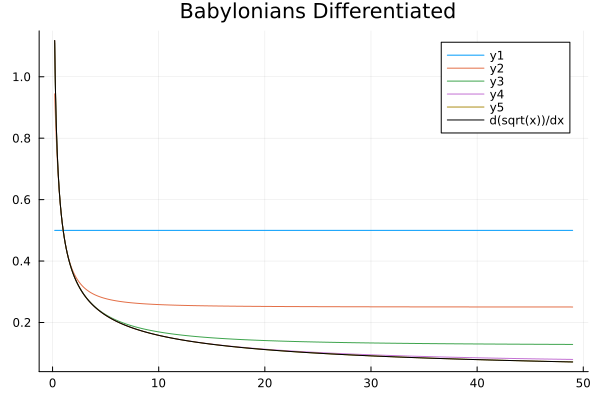

In [16]:
i = .2:.01:49
plot([x->Babylonian(D((x,1.0)),N=i).f[2] for i=1:5],i)
plot!(x->.5/√x,i,c="black",label="d(sqrt(x))/dx",
    title = " Babylonians Differentiated")

## It just works!

How does it work?  We will explain in a moment.  Right now marvel that it does.  Note we did not
import any autodiff package.  Everything is just basic vanilla Julia.

## The assembler

Most folks don't read assembler, but one can see that it is short.

In [17]:
# @inline function Babylonian(x; N = 10) 
#     t = (1+x)/2
#     for i = 2:N; t=(t + x/t)/2  end    
#     t
# end  
@code_native(Babylonian(D((2,1))))

	.section	__TEXT,__text,regular,pure_instructions
	.build_version macos, 14, 0
	.globl	_julia_Babylonian_1671          ## -- Begin function julia_Babylonian_1671
	.p2align	4, 0x90
_julia_Babylonian_1671:                 ## @julia_Babylonian_1671
; ┌ @ In[1]:1 within `Babylonian`
## %bb.0:                               ## %top
	push	rbx
	sub	rsp, 16
	mov	rdx, rsi
	mov	rbx, rdi
	movabs	rax, offset "_j_#Babylonian#1_1673"
	mov	rdi, rsp
	mov	esi, 10
	call	rax
	vmovups	xmm0, xmmword ptr [rsp]
	vmovups	xmmword ptr [rbx], xmm0
	mov	rax, rbx
	add	rsp, 16
	pop	rbx
	ret
; └
                                        ## -- End function
.subsections_via_symbols


## Symbolically

We haven't yet explained how it works, but it may be of some value to understand that the below is mathematically
equivalent, though not what the computation is doing.

Notice in the below that Babylonian works on SymPy symbols.

In [18]:
#Pkg.add("SymPy")
using SymPy                    

In [19]:
x = symbols("x")
display("Iterations as a function of x")
for k = 1:5
 display( simplify(Babylonian(x,N=k)))
end

display("Derivatives as a function of x")
for k = 1:5
 display(simplify(diff(simplify(Babylonian(x,N=k)),x)))
end

"Iterations as a function of x"

x   1
─ + ─
2   2

           2
    (x + 1) 
x + ────────
       4    
────────────
   x + 1    

 4       3       2           
x  + 28⋅x  + 70⋅x  + 28⋅x + 1
─────────────────────────────
     ⎛ 3      2          ⎞   
   8⋅⎝x  + 7⋅x  + 7⋅x + 1⎠   

 8        7         6         5          4         3         2            
x  + 120⋅x  + 1820⋅x  + 8008⋅x  + 12870⋅x  + 8008⋅x  + 1820⋅x  + 120⋅x + 1
──────────────────────────────────────────────────────────────────────────
         ⎛ 7       6        5        4        3        2           ⎞      
      16⋅⎝x  + 35⋅x  + 273⋅x  + 715⋅x  + 715⋅x  + 273⋅x  + 35⋅x + 1⎠      

 16        15          14           13             12             11          
x   + 496⋅x   + 35960⋅x   + 906192⋅x   + 10518300⋅x   + 64512240⋅x   + 2257928
──────────────────────────────────────────────────────────────────────────────
               ⎛ 15        14         13           12           11            
            32⋅⎝x   + 155⋅x   + 6293⋅x   + 105183⋅x   + 876525⋅x   + 4032015⋅x

    10              9              8              7              6            
40⋅x   + 471435600⋅x  + 601080390⋅x  + 471435600⋅x  + 225792840⋅x  + 64512240⋅
──────────────────────────────────────────────────────────────────────────────
10             9             8             7             6            5       
   + 10855425⋅x  + 17678835⋅x  + 17678835⋅x  + 10855425⋅x  + 4032015⋅x  + 8765

 5             4           3          2            
x  + 10518300⋅x  + 906192⋅x  + 35960⋅x  + 496⋅x + 1
───────────────────────────────────────────────────
    4           3         2            ⎞           


"Derivatives as a function of x"

1/2

   2            
  x  + 2⋅x + 5  
────────────────
  ⎛ 2          ⎞
4⋅⎝x  + 2⋅x + 1⎠

 6       5        4        3        2             
x  + 14⋅x  + 147⋅x  + 340⋅x  + 375⋅x  + 126⋅x + 21
──────────────────────────────────────────────────
  ⎛ 6       5       4        3       2           ⎞
8⋅⎝x  + 14⋅x  + 63⋅x  + 100⋅x  + 63⋅x  + 14⋅x + 1⎠

 14       13         12          11           10            9            8    
x   + 70⋅x   + 3199⋅x   + 52364⋅x   + 438945⋅x   + 2014506⋅x  + 5430215⋅x  + 8
──────────────────────────────────────────────────────────────────────────────
      ⎛ 14       13         12          11           10           9           
   16⋅⎝x   + 70⋅x   + 1771⋅x   + 20540⋅x   + 126009⋅x   + 440986⋅x  + 920795⋅x

        7            6            5            4           3          2       
836200⋅x  + 8842635⋅x  + 5425210⋅x  + 2017509⋅x  + 437580⋅x  + 52819⋅x  + 3094
──────────────────────────────────────────────────────────────────────────────
8            7           6           5           4          3         2       
  + 1173960⋅x  + 920795⋅x  + 440986⋅x  + 126009⋅x  + 20540⋅x  + 1771⋅x  + 70⋅x

       
⋅x + 85
───────
    ⎞  
 + 1⎠  

 30        29          28            27              26               25      
x   + 310⋅x   + 59799⋅x   + 4851004⋅x   + 215176549⋅x   + 5809257090⋅x   + 102
──────────────────────────────────────────────────────────────────────────────
                     ⎛ 30        29          28            27             26  
                  32⋅⎝x   + 310⋅x   + 36611⋅x   + 2161196⋅x   + 73961629⋅x   +

           24                  23                   22                   21   
632077611⋅x   + 1246240871640⋅x   + 10776333438765⋅x   + 68124037776390⋅x   + 
──────────────────────────────────────────────────────────────────────────────
             25                24                 23                  22      
 1603620018⋅x   + 23367042639⋅x   + 238538538360⋅x   + 1758637118685⋅x   + 957

                 20                     19                     18             
321156247784955⋅x   + 1146261110726340⋅x   + 3133113888931089⋅x   + 6614351291
──────────────────────────────────────────────────

## How autodiff is getting the answer
Let us by hand take the "derivative" of the Babylonian iteration with respect to x. Specifically t′=dt/dx

In [20]:
function dBabylonian(x; N = 10) 
    t = (1+x)/2
    t′ = 1/2
    for i = 1:N;  
        t = (t+x/t)/2; 
        t′= (t′+(t-x*t′)/t^2)/2; 
    end    
    t′

end  

dBabylonian (generic function with 1 method)

In [21]:
x = π; dBabylonian(x), .5/√x

(0.2820947917738782, 0.28209479177387814)

What just happened?  Answer: We created an iteration by hand for t′ given our iteration for t. Then we ran the iteration alongside the iteration for t.

In [22]:
Babylonian(D((x,1)))


D((1.7724538509055159, 0.28209479177387814))

How did this work?  It created the same derivative iteration, using very general rules that are set once and need not be written by hand.

Important:: The derivative is substituted before the JIT compiler, and thus efficient compiled code is executed.

## Dual Number Notation

Instead of D(a,b) we can write a + b ϵ, where ϵ satisfies ϵ^2=0.  (Some people like to recall imaginary numbers where an i is introduced with i^2=-1.) 

Others like to think of how engineers just drop the O(ϵ^2) terms.

The four rules are

$ (a+b\epsilon) \pm (c+d\epsilon) = (a \pm c) +  (b \pm d)\epsilon$

$ (a+b\epsilon) * (c+d\epsilon) = (ac) + (bc+ad)\epsilon$

$ (a+b\epsilon) / (c+d\epsilon) = (a/c) + (bc-ad)/c^2 \epsilon $


In [23]:
@syms a b c d ϵ

(a, b, c, d, ϵ)

In [24]:
series((a+b*ϵ)/(c+d*ϵ),ϵ,0,2)

  ⎛  a⋅d   b⎞   a    ⎛ 2⎞
ϵ⋅⎜- ─── + ─⎟ + ─ + O⎝ϵ ⎠
  ⎜    2   c⎟   c        
  ⎝   c     ⎠            

In [25]:
Base.show(io::IO,x::D) = print(io,x.f[1]," + ",x.f[2]," ϵ")

In [26]:
# Add the last two rules
import Base: -,*
-(x::D, y:: D) = D(x.f .- y.f)
*(x::D, y::D) = D((x.f[1]*y.f[1], (x.f[2]*y.f[1] + x.f[1]*y.f[2])))

* (generic function with 348 methods)

In [27]:
D((1,0))

1.0 + 0.0 ϵ

In [28]:
D((2,1)) ^2

4.0 + 4.0 ϵ

In [29]:
ϵ = D((0,1))


0.0 + 1.0 ϵ

In [30]:
ϵ * ϵ 

0.0 + 0.0 ϵ

In [31]:
ϵ^2


0.0 + 0.0 ϵ

In [32]:
1/(1+ϵ)  # Exact power series:  1-ϵ+ϵ²-ϵ³-...

1.0 + -1.0 ϵ

In [33]:
(1+ϵ)^5  ## Note this just works (we didn't train powers)!!

1.0 + 5.0 ϵ

In [34]:
(1+ϵ)^(-1)

1.0 + -1.0 ϵ

## Generalization to arbitrary roots

In [35]:
function nthroot(x, n=2; t=1, N = 10) 
    for i = 1:N;   t += (x/t^(n-1)-t)/n; end   
    t
end  

nthroot (generic function with 2 methods)

In [36]:
nthroot(2,3), ∛2 # take a cube root

(1.2599210498948732, 1.2599210498948732)

In [37]:
nthroot(2+ϵ,3)

1.2599210498948732 + 0.20998684164914552 ϵ

In [38]:
nthroot(7,12), 7^(1/12)

(1.1760474285795146, 1.1760474285795146)

In [39]:
x = 2.0
nthroot( x+ϵ,3), ∛x, 1/x^(2/3)/3

(1.2599210498948732 + 0.20998684164914552 ϵ, 1.2599210498948732, 0.20998684164914552)

## Forward Diff
Now that you understand it, you can use the official package

In [40]:
# using Pkg
# Pkg.add("ForwardDiff")

In [41]:
using ForwardDiff

In [42]:
ForwardDiff.derivative(sqrt, 2)

0.35355339059327373

In [43]:
ForwardDiff.derivative(Babylonian, 2)

0.35355339059327373

In [44]:
@which ForwardDiff.derivative(sqrt, 2)

derivative(f::F, x::R) where {F, R<:Real}
     @ ForwardDiff ~/.julia/packages/ForwardDiff/PcZ48/src/derivative.jl:12